# FIRST CUDA NOTEBOOK

**Authors of homework:**
+ Mireia Kesti
+ Aleksandra Jamróz


The NVidia GPUs must be programmed using CUDA programming language.
CUDA is a non standard C language.

We assume there was CUDA Development Kit installed in the computer.

This Notebook is designed to be executed in Google Colaboratory

This three first cells are used just to know our architecture, and limits. It is important to know: maximum number of parallel threads per block, and maximum block size.

The command **nvidia-smi** allows us to know the state of the GPU device.

Without parameters, it will show the GPU model, and processes which are running in the GPU.

In [ ]:
# use ! to access shell commands
# allows us to know the state of the GPU device. Without parameters, it will show the GPU model, and processes which are running in the GPU.
!nvidia-smi

With nvidia-smi -q, it will show us in more details the GPU information and configuration. But it does not show all the information.

In [ ]:
# get more details about the GPU info & configuration. Does not show all the info.
!nvidia-smi -q

The command deviceQuery is a example command installed with the standard CUDA Development Kit, but allow us to know more details about the GPU like the number of cores.

Now, we will install the pycuda module in the colaboratory environment, to combine python and CUDA in our code. Because pycuda is not available by default, this task can take a few minutes.

In [ ]:
# Unomment the follow line if you are using Google Colaboratory
# !pip install pycuda

# MODULES LOAD
We import the Python modules which we will use in the notebook (numpy, pycuda and time module) 

In [ ]:
import  numpy  as  np
import  pycuda.autoinit                         #This submodule of the PyCUDA  initialize the driver connection with youd GPU Device
from    pycuda.compiler import SourceModule     #This submodule provides the interface with the CUDA Compiler
import  pycuda.driver as  drv                   #This submodule provides the interface with the GPU device
import  pycuda.gpuarray as  gpuarray            #This submodule provides the interface with the Memory allocation methods
from sys import getsizeof
import time

In [ ]:
NUM_GPUS = pycuda.driver.Device(0).count()
print("Number of GPUs available: {0}".format(NUM_GPUS))

In [ ]:
if NUM_GPUS > 0:
    print("GPU Model: {0}".format(pycuda.driver.Device(0).name()))

In [ ]:
if NUM_GPUS > 0:
    GPU_ATTRIBUTES = pycuda.driver.Device(0).get_attributes()

In [ ]:
for f in GPU_ATTRIBUTES.keys():
    print("{0}:\t{1}".format(f,GPU_ATTRIBUTES[f]))

The most important attributes in our case will be:

In [ ]:
if NUM_GPUS > 0:
    print("Max blocks per multiprocessor:\t\t",GPU_ATTRIBUTES[pycuda.driver.device_attribute.MAX_BLOCKS_PER_MULTIPROCESSOR])
    print("Multiprocessors count:\t\t\t",GPU_ATTRIBUTES[pycuda.driver.device_attribute.MULTIPROCESSOR_COUNT])
    print("Max number of concurrent processes:\t",GPU_ATTRIBUTES[pycuda.driver.device_attribute.MAX_BLOCKS_PER_MULTIPROCESSOR]*GPU_ATTRIBUTES[pycuda.driver.device_attribute.MULTIPROCESSOR_COUNT])
    print("Max block size X axis:\t\t\t",GPU_ATTRIBUTES[pycuda.driver.device_attribute.MAX_BLOCK_DIM_X])
    print("Max block size Y axis:\t\t\t",GPU_ATTRIBUTES[pycuda.driver.device_attribute.MAX_BLOCK_DIM_Y])
    print("Max block size Z axis:\t\t\t",GPU_ATTRIBUTES[pycuda.driver.device_attribute.MAX_BLOCK_DIM_Z])
    print("Max threads per multiprocessor:\t\t",GPU_ATTRIBUTES[pycuda.driver.device_attribute.MAX_THREADS_PER_MULTIPROCESSOR])

In [ ]:
if NUM_GPUS > 0:
    (GPU_MEM_FREE,GPU_MEM_TOTAL)=pycuda.driver.mem_get_info()
    print("Total memory device: {0} ({1} GBytes)".format(GPU_MEM_TOTAL,GPU_MEM_TOTAL/(1024*1024*1024)))
    print("Free memory device: {0} ({1} GBytes)".format(GPU_MEM_FREE,GPU_MEM_FREE/(1024*1024*1024)))


More info in:
https://en.wikipedia.org/wiki/List_of_Nvidia_graphics_processing_units

# RECOVER CONTROL
If you lost the control of your GPU, you can recover it executing the follow shell command:

In [ ]:
!nvidia-smi --gpu-reset

If the previous command does not work, you will have to restart the Python Kernel (to release and reset the GPU).
In the worst case, you will have to restart the computer or the virtual environment (in Google Colab)

### When do you lose control?
The most common error is not well handled memory, exceeding the memory boundaries.

# BASIC CONCEPTS WHILE PROGRAMMING FOR GPUs:

The GPU programming philosophy is a SIMD programming: **Single Instruction Multiple Data** programming. That means: You will apply the same code (or set of instructions) at the same time to many data.

To achieve this behaviour, the GPU devices will assign each processor it haves a thread which will execute your program (in this case we will name it **kernel**) to different data, previousle uploaded to the GPU's main memory.

So, when you are programming your kernel, you have to think: Which basic data I will receive (just one number, a set of numbers, a region of data), and how will process it, and store in other portion of global memory.

Your kernel should not depend on the exitance of other parallel processes, and should not write the results in a memory portion used by other processes.

The GPUs operating system (if we can call it *operating system*) is a very basic O.S. which does not controll memory access.

Because we will not have as sufficient number of processors as data, we will need to divide our data in blocks. Each block can be a two dimensional block identifier, with X and Y coordinates.

The block identifier will be blockIdx, and it is a data record with fields x and y. (blockIdx.x and blockIdx.y). 

With this indexes, we can go through all the data to process

Each block of data instead can be a three dimensional block of data, that means, the block will have dimension in x-axis, y-axis and z-axis. The dimension must go from 1 up to maximum block size defined by the GPU architecture. The variable provided to know the block size is blockDim and it is a record with three fields: x,y and z.

Internally, each block will have assigned $blockDim.x * blockDim.y * blockDim.z$ threads, and for each thread the device will assign one core. The number of maximum threads per block is limited by the GPU's architecture.

Each thread is identified by the varible threadIdx, and its coordinates inside the block defined by the fields x,y and z.

* The variable threadIdx.x will be limited by the boundaries $0 \le threadIdx.x <blockDim.x$.

* The variable threadIdx.y will be limited by the boundaries $0\le threadIdx.y < blockDim.y$.

* The variable threadIdx.x will be limited by the boundaries $0\le threadIdx.z <blockDim.z$.



Those variables are created and handled directly by the GPU's O.S.

Each block of data assigned to your kernel execution will be addressed using the combination of those three variables threadIdx, blockDim, and blockIdx.

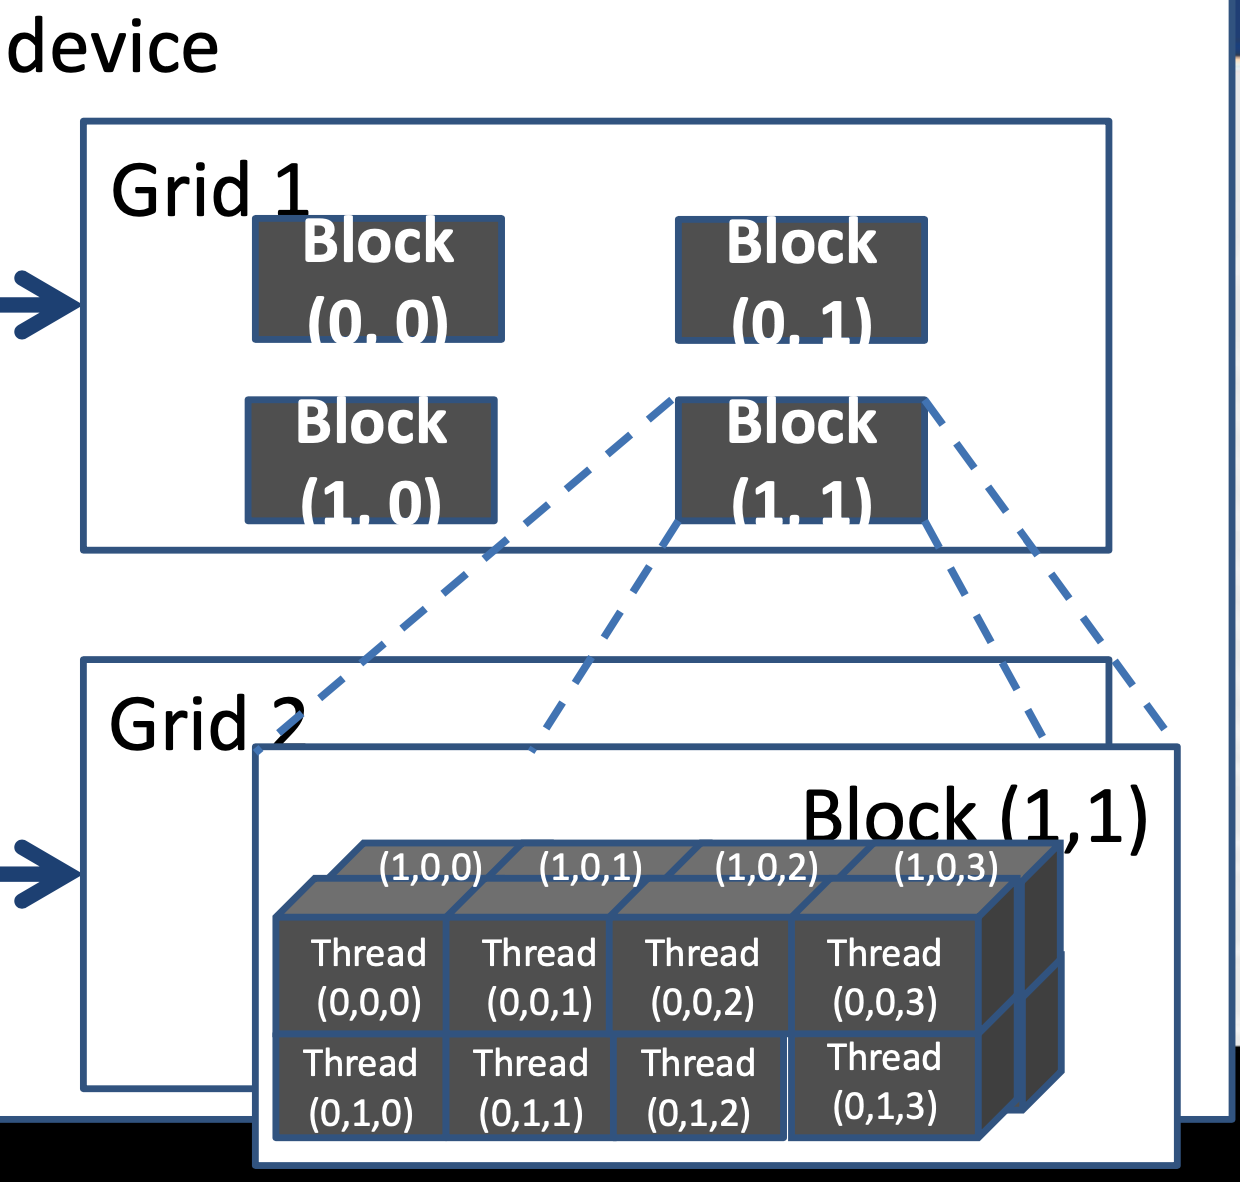

You have to define the blockDim to cover a block of data without exceed the maximum number of threads per block allowed by the GPU's architecture.

You have to define the number of blocks to cover all the data you will have to process.

Because the kernels do not controlls the memory assigned boundaries, the first thing you will have to analyze MUST be if your calculated data position is a valid position in your memory assigned.

The GPUs always handle the memory as a vector of data, so it stores more complex data structures, like matrixes, as a row-wise matrix, that means a  vector of rows, or column-wise matrix, a vector of columns.

If you wants to locate a memory position (r,c) in a matrix of M rows and N columns, in a row-wise matrix representation, with $0\le r < M$, and $0\le c <N$, the index $i= r*N+c$.

In a similar way, if the matrix is a column-wise representation, the index i will be $i=c*M+r$

If you have more than 1 block, you will need to use the block identifier to index the data in your memory vector.

![image.png](attachment:e8bd3709-a3b6-4329-8351-ba36732cbc45.png)


# FIRST KERNEL
## Calculate the vector position in a transfered matrix

This first kernel, we need to calculate the position of each one of the matrix cells in the vector created in the GPU memory.

The steps will be:
* Create our local variables using NumPY
* Allocate the memory in the GPU memory and the local reference using *gpuarray* method
* Write our code. We will write our code in a String variable
* Compile the code using the SourceModule method. This method will invoke the CUDA compiler and upload the kernel to the device
* Get the local reference for the uploade GPU function
* Define the block dimensions and number of blocks in all axis
* Invoke the GPU method to be executed
* Fetch the results, copying the data from the GPU memory reference to local reference.

**Create our local variables**

In [ ]:
NUM_ROWS = 2048
NUM_COLUMNS = 2048
matrix_A = np.zeros((NUM_ROWS,NUM_COLUMNS),dtype=np.int32)

**Allocate the memory in the GPU**

In [ ]:
matrix_A_GPU = gpuarray.to_gpu(matrix_A) # A gpuArray object represents an array stored in GPU memory.

**Write our code**
We have to write our code thinking what have to do each individual execution thread over each one of the data cells.
* The first step is identify where we are. To do this:
    * we need to identify which block are we modifying. We will use the block identifier structure blockIdx with his fields x,y and z.
    * Once identified the block, check where in the block we are, using the threadIdx structure with the fields x,y and z.
    * Check if we are inside the boundaries of memory

In [ ]:
KERNEL_DATA_INDEX_SRC="""
__global__ void data_index(unsigned int* m, int num_rows, int num_columns) 
//Our parameters are:
// m: pointer to the memory allocated where we will save the data. The data to store is unsigned integer of 32 bits
// num_rows: number of rows in our original matrix, this dimension is of type integer
// num_columns: number of columns in our original matrix,  this dimension is of type integer
{ 
    //In C we need to define the variables and its type before use they
    
    unsigned int bIdx, bIdy;
    unsigned int x_offset, y_offset;
    unsigned int dimX, dimY;
    
    unsigned int x_coordinate, y_coordinate, v_coordinate;
    
    //Very important thing: always end your code line with semicolon ;
    
    //First: identify the block
    bIdx = blockIdx.x;
    bIdy = blockIdx.y;
    
    //We are working with two dimensional block array, so we will not analyze the z axis.
    //Now: identify the asigned cell in the block.
    x_offset = threadIdx.x;
    y_offset = threadIdx.y;
    
    //Fetch the size of each block using the record blockDim
    dimX = blockDim.x;
    dimY = blockDim.y;
    
    x_coordinate = bIdx * dimX + x_offset; //this is the column in our matrix
    y_coordinate = bIdy * dimY + y_offset;  //this is the row in our matrix;
    
    //Now, you have to check the boundaries, using the num_rows and num_columns
    //WRITE HERE THE CHECKING AND MODIFY THE CODE - written

    if (( x_coordinate < num_columns ) && (y_coordinate < num_rows)) {

    //Here, we calculate the position in the vector
      v_coordinate = y_coordinate * num_columns + x_coordinate;
    
      m[v_coordinate] = v_coordinate;
    }
}
"""

**Now, we compile the code**

The compilation only means the code is sytanctically correct, but it doesn't mean that it works well.

In [ ]:
kernel_data_index  =  SourceModule (KERNEL_DATA_INDEX_SRC)

**Get the local reference for the uploade GPU function**

data_index_function will be our local function reference, to invoke from python.

In [ ]:
data_index_function = kernel_data_index.get_function("data_index")

**Define the block dimensions and number of blocks in all axis**

We need to define the block dimensions and the size of our block array to cover all the cells in the matrix
To define the block dimenstion we need to analyze the maximum size of block which does not exceed the **max threads per block** value, and trying to not leave **Max threads per multiprocessor** free.
Other constraints are:
* not exceed the number of executional blocks
* not exceed the number of block arrays
* take care about the GPU global memory

In most of the cases the size 16x16x1 is a good compromise values.


In [ ]:
block_sizeX = int(16)
block_sizeY = int(16)

In [ ]:
block_size = (block_sizeX, block_sizeY,1)

In [ ]:
num_blocksX = int(np.ceil(NUM_COLUMNS/block_sizeX))     # round number up to the nearest integer (if necessary)
num_blocksY = int(np.ceil(NUM_ROWS/block_sizeY))        # We need to cast to integer data type, because the parameter MUST be an integer value and ceil, floor and round returns double values
grid_size = (num_blocksX, num_blocksY, 1)
# We use ceil, and not round or floor, because we have to be able to fit all our data


**Invoke the GPU method to be executed**

In [ ]:
data_index_function(matrix_A_GPU,
                    np.uint32(NUM_ROWS),
                    np.uint32(NUM_COLUMNS),
                    block=block_size,
                    grid=grid_size)

In [ ]:
matrix_A_final = matrix_A_GPU.get()

In [ ]:
matrix_A_final[0,0:10]

In [ ]:
matrix_A_final[0:10,0]

### YOUR WORK:
Modify the KERNEL_DATA_INDEX_SRC code, to verify the coordinates of the selected cell and check if it is inside our matrix boundaries.

To verify it, use the follow matrix, which the remains of the division of columns/block_sizeX and rows/block_sizeY is not 0

In [ ]:
NUM_ROWS_B = 2010
NUM_COLUMNS_B = 2010
matrix_B = np.zeros((NUM_ROWS_B,NUM_COLUMNS_B),dtype=np.int32)

In [ ]:
matrix_B_GPU = gpuarray.to_gpu(matrix_B)

In [ ]:
num_blocksX_B = int(np.ceil(NUM_COLUMNS_B/block_sizeX))
num_blocksY_B = int(np.ceil(NUM_ROWS_B/block_sizeY))
grid_size_b = (num_blocksX_B,num_blocksY_B,1)

### WARNING!!!

If you run the next cell, it will be "executed" but unable to recover the information.
It will generate an error message about being unable to access to device memory.
To avoid this problem, fist you have to modify the code to avoid exceed the memory boundaries.

*Update: modified* 

In [ ]:
data_index_function(matrix_B_GPU,
                    np.uint32(NUM_ROWS_B),
                    np.uint32(NUM_COLUMNS_B),
                    block=block_size,
                    grid=grid_size_b)

In [ ]:
matrix_B_final = matrix_B_GPU.get()

In [ ]:
matrix_B_final[0,0:10]

In [ ]:
matrix_B_final[0:10,0]

# SECOND KERNEL

Calculate the square value of each position in a vector of size 1000000

In [ ]:
SQUARE_SRC="""
__global__ void square(float* a, float* b, int n) 
{ 
    //Vector a stores the numbers to analyze (all of them)
    //Vector b is where we will store the sum of all numbers in the block assigned
    //n is the number of elements in the vector
    
    unsigned int vector_idx;
    float o;
    
    // You have to identify which block is assigned to this kernel, using the blockIdentifier blockIdx.x, 
    // check the boundaries and calculate the sum of this portion of data
    // This instruction calculates in the offset in the memory data, based on the block identificator blockIdx.x

    vector_idx = blockIdx.x * blockDim.x + threadIdx.x;

    // Once identified the vector position, fetch the value, calculate the square of the data and save it 
    // in the b vector, in the correct position.

    if (vector_idx < n){
      o = a[vector_idx];
      b[vector_idx] = o*o;
    }
    
    return;
}
"""

In [ ]:
kernel_square  =  SourceModule (SQUARE_SRC)

Here, we define the python reference for the summatory function

In [ ]:
square_function = kernel_square.get_function ('square')

We define our vector size

In [ ]:
n = np.int32(1000000)

Here, we initialize our sample vector, of type float32, again, due the GPU word size 

In [ ]:
a = np.random.randn(n).astype(np.float32)

Upload our data to the GPU

In [ ]:
a_gpu = gpuarray.to_gpu( a )

Now, we will define our block size to 256

In [ ]:
block_size = int(256)

Calculate the number of blocks in which we will have to split our vector (in the GPU)

In [ ]:
num_blocks = int(np.ceil(n*1.0/block_size))

In [ ]:
num_blocks

Create our result vector

In [ ]:
b = np.zeros((n,),dtype=np.float32)

Create the variable in the GPU

In [ ]:
b_gpu = gpuarray.to_gpu( b )

And now, we have to calculate the square values of each element in the vector

In [ ]:
square_function( 
       a_gpu,
       b_gpu,
       n,
       block=(block_size,1,1),
       grid=(num_blocks,1)
       )


Get the result using CPU numpy sum over our vector

In [ ]:
b_numpy = np.square(a)

In [ ]:
b_numpy[10]

And collect from the GPU the result vector s, an check the value stored in the position 0

In [ ]:
b = b_gpu.get()

In [ ]:
print(b[10])

In [ ]:
sum(abs(b-b_numpy))

Check possible differences, and why do you think it is happening? 

(Nothing is happening, the algorithm and the code are ok).

# Matrix Multiplication
We have 2 matrix multiplication, of size 1000x500 and 500x300

The fist step is write or code.

Here, each computational thread will calculate the assigned cell in the result matrix c;
That is why the block grid is referenced to that matrix.

You have to:
* calculate the correspondent row and column of the assigned thread
* check if it is in the boundaries
* create a for loop to walk through the columns matrix a and calculate the memory position in the vector. You have to do the same thing in the matrix b, but walking through his rows
* acummulate the product
* save the product in the memory position in the matrix c

Easy :-D

In [ ]:
MATRIX_MULT_SRC="""
__global__ void matrix_mult(float* a, 
                            float* b, 
                            float* c, 
                            int m, 
                            int n, 
                            int o) 
{ 
  // a is the vector which represents the matrix_a
  // b is the vector which represents the matrix_b
  // c is the vector where we will store the resulting matrix
  // m is number of rows of matrix a
  // n is the number of columns of matrix a, and number of rows of matrix b
  // o is the number of columns of matrix b
  // First task: Using threadIdx.x, threadIdx.y, blockDim.x, blockDim.y, 
  // blockIdx.x, blockDim.y identify the coordinates x and y in the result matrix
  // implements the matrix multiplication, cell by cell using the conventional code and analyze
  
  int idx;
  int cell_a, cell_b, start_row, start_column;
  float accu = 0;

  int column, row;
  column = blockIdx.x * blockDim.x + threadIdx.x;
  row    = blockIdx.y * blockDim.y + threadIdx.y;
  idx = row * o + column;
  
  if ((column < o) && (row < m)){
    
    // MODIFIED ROW, MIREIA, LOOK HERE: first row previous commented, second mine
    // It is only modification I added but I think it works? The arrays are really similar
    // I think differences of sizes 0.0001 can be from float / int variables types differences
    // BY THE WAY IT'S CORRECT BECAUSE HE CHANGED IT IN CLASS BUT DIDN'T UPLOAD IT
    // start_row = row * o;     
    start_row = row * n;
    
    for (int i = 0; i < n; i++) {
      start_column = column;
      cell_a = start_row + i;
      cell_b = start_column + i * o;
      accu += a[cell_a] * b[cell_b];
    }

    c[idx] = accu;
  }
}
"""

In [ ]:
# compiling code
kernel_matrix_mult  =  SourceModule (MATRIX_MULT_SRC)

In [ ]:
# getting local reference for uploaded GPU function
matrix_mult = kernel_matrix_mult.get_function("matrix_mult")

Here, we define our variables a,b and c, and uploaded it to the GPU.

In [ ]:
m = 900             # number of rows of matrix a
n = 500             # number of columns of matrix a, and number of rows of matrix b
o = 200             # number of columns of matrix b

In [ ]:
# generating matrices:
matrix_a = np.random.randn(m, n).astype(np.float32)
matrix_b = np.random.randn(n, o).astype(np.float32)
matrix_c = np.zeros((m, o),dtype=np.float32)            # result matrix

In [ ]:
# allocating memory in the GPU 
matrix_a_gpu = gpuarray.to_gpu(matrix_a)
matrix_b_gpu = gpuarray.to_gpu(matrix_b)
matrix_c_gpu = gpuarray.to_gpu(matrix_c)

Now, we configure the block size and grid size to cover the result matrix c

In [ ]:
block_size = (int(16), int(16), 1)
numblocks_x = int(np.ceil(o/16))
numblocks_y = int(np.ceil(m/16))
grid_size = (numblocks_x, numblocks_y, 1)

Then, invoke our kernel.

In [ ]:
%%time
matrix_mult(matrix_a_gpu,
            matrix_b_gpu,
            matrix_c_gpu,
            np.int32(m),
            np.int32(n),
            np.int32(o),
            block=block_size,
            grid=grid_size)

And then, fetch the result

In [ ]:
matrix_c_final = matrix_c_gpu.get()

Now, we can compare with the local computed matrix c, and check the differences.

In [ ]:
%%time
# matrix multiplication done with numpy
matrix_c_numpy = np.matmul(matrix_a,matrix_b)

In [ ]:
matrix_c_final[0:5,0:5]

In [ ]:
matrix_c_numpy[0:5,0:5]

In [ ]:
# differences between results of numpy and gpu matrixes multiplications
abs(abs(matrix_c_numpy)-abs(matrix_c_final))

### Conclusions:
For all performed calculations, those on GPU were much faster than those on CPU. That clearly proves advantage of graphical units.

In other python notebook we tested cupy library and made some experiments with it. Results of our work are in my partner's Mireia notebook. It worked better than numpy, so we consider using it in the future.

As we saw problems with our work on google colab, I decided to take advantage of possibilities of my hardware, because I have nvidia gpu in my computer (NVIDIA GeForce MX150). Using local environment to execute code is really enjoyable, because after installing all necessary tools, work doesn't generate so many problems as outside environment. 